In [2]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import librosa

print(torch.__config__.show())

PyTorch built with:
  - GCC 4.2
  - C++ Version: 201703
  - clang 15.0.0
  - OpenMP 201811
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: NO AVX
  - Build settings: BLAS_INFO=accelerate, BUILD_TYPE=Release, COMMIT_SHA=e2d141dbde55c2a4370fac5165b0561b6af4798b, CXX_COMPILER=/usr/bin/c++, CXX_FLAGS= -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DLIBKINETO_NOXPUPTI=ON -DUSE_PYTORCH_QNNPACK -DAT_BUILD_ARM_VEC256_WITH_SLEEF -DUSE_XNNPACK -DUSE_PYTORCH_METAL_EXPORT -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -DUSE_COREML_DELEGATE -O2 -fPIC -Wall -Wextra -Werror=return-type -Werror=non-virtual-dtor -Werror=braced-scalar-init -Werror=range-loop-construct -Werror=bool-operation -Wnarrowing -Wno-missing-field-initializers -Wno-unknown-pragmas -Wno-unused-parameter -Wno-strict-overflow -Wno-strict-aliasing -Wvla-extension -Wsuggest-override -Wnewline-eof -Winconsistent-missing-override -Wincon

Need to check the windows are the same
Need to check that the processing at each step is the same for the windowed data
Need to check the fft data results

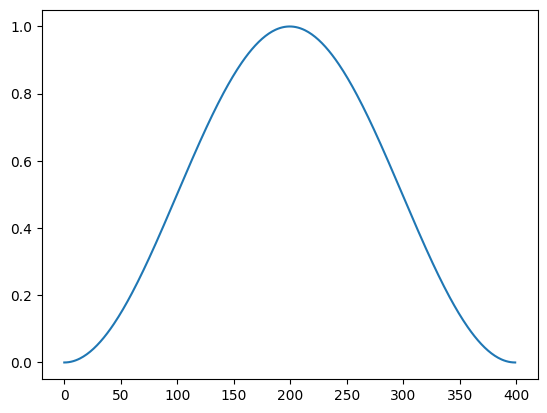

In [ ]:
x = torch.hann_window(400, periodic=False)
plt.plot(xn)
xn = x.numpy()


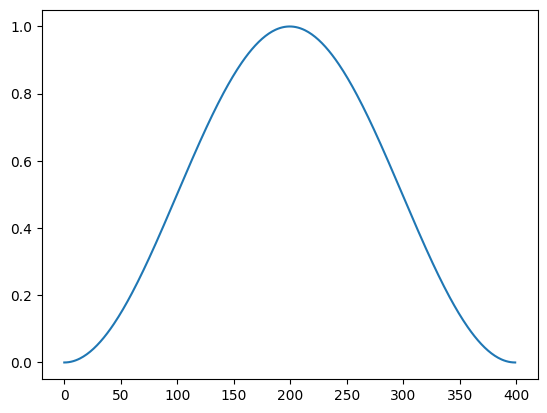

In [22]:
import struct
import numpy as np

def read_1dc_array_binary(file_path):
    with open(file_path, 'rb') as f:
      
        data = np.fromfile(f, dtype=np.float32)
    
    return data

def read_1dc_dblarray_binary(file_path):
    with open(file_path, 'rb') as f:
      
        data = np.fromfile(f, dtype=np.float64)
    
    return data


def read_2dc_array_binary(file_path):
    with open(file_path, 'rb') as f:
        # Read the dimensions (rows and columns)
        rows = struct.unpack('i', f.read(4))[0]  # Read 4 bytes (integer)
        cols = struct.unpack('i', f.read(4))[0]  # Read 4 bytes (integer)

        # Read the array data into a NumPy array
        data = np.fromfile(f, dtype=np.float32, count=rows * cols)

        # Reshape the data into a 2D array (rows x cols)
        array = data.reshape((rows, cols))
    
    return array


file_path = '/Users/ken/Documents/sigwin400.bin'  # Adjust as needed
xcnew = read_1dc_dblarray_binary(file_path)
plt.plot(xcnew)



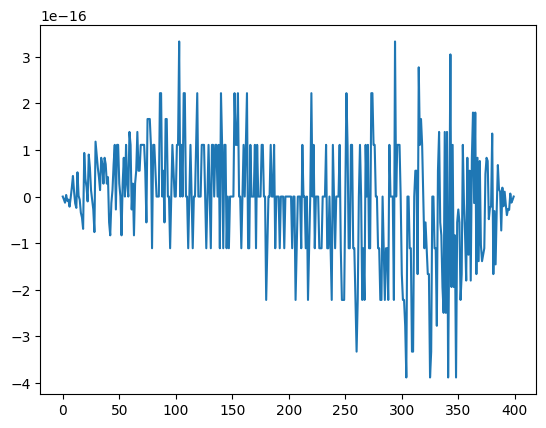

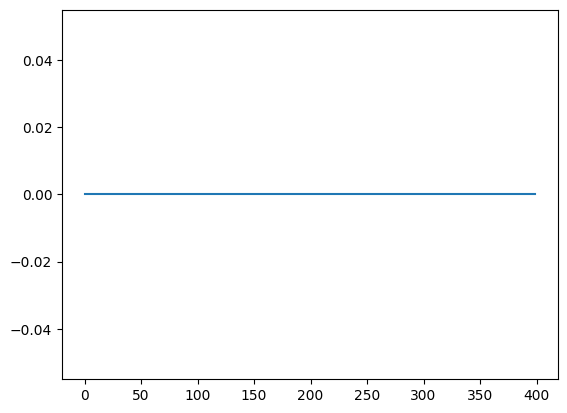

In [26]:
plt.plot(window - xcnew)
plt.show()
winf = window.astype(np.float32)
xcnewf = xcnew.astype(np.float32)
plt.plot(winf - xcnewf)


# Conclude that there is a difference in the hanning windows
# My hanning window is the same as the numpy, pytorchs is different
# But if I do all calculations as doubles, import them and then convert to float, it is the same as torch


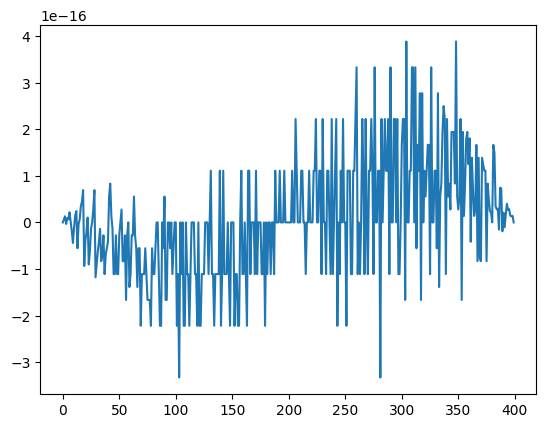

0.0
1.4997598e-32
0.0
0.0


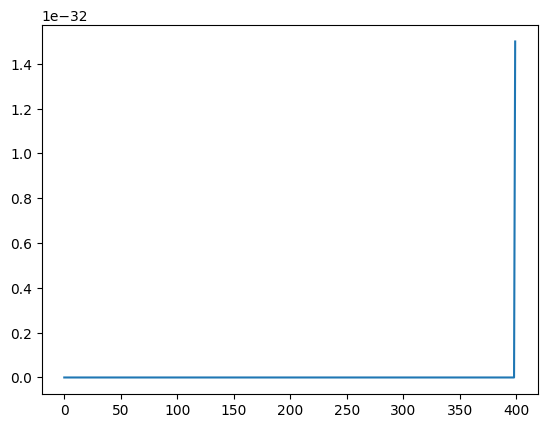

In [21]:
window = np.hanning(400)
plt.plot(xcnew - window)
plt.show()

#print(xn[195:205])
#print(xc[195:205])
#print(window[195:205])

window.dtype
winf = window.astype(np.float32)
xcnewf = xcnew.astype(np.float32)
plt.plot(xcnewf - winf)

print(xcnew[0])
print(xcnewf[-1])
print(winf[-1])
print(winf[0])


## Looking at the Mel filterbanks now
# First check the kaldi outputs

In [ ]:
import math

def inverse_mel_scale(mel_freq):
    return 700.0 * ((mel_freq / 1127.0).exp() - 1.0)



def mel_scale(freq):
    return 1127.0 * (1.0 + freq / 700.0).log()



def mel_scale_scalar(freq):
    return 1127.0 * math.log(1.0 + freq / 700.0)



def get_mel_banks(
    num_bins: int,
    window_length_padded: int,
    sample_freq: float,
    low_freq: float,
    high_freq: float,
): 
    """
    Returns:
        (Tensor, Tensor): The tuple consists of ``bins`` (which is
        melbank of size (``num_bins``, ``num_fft_bins``)) and ``center_freqs`` (which is
        center frequencies of bins of size (``num_bins``)).
    """


    num_fft_bins = window_length_padded / 2
    nyquist = 0.5 * sample_freq

    high_freq = nyquist

    # fft-bin width [think of it as Nyquist-freq / half-window-length]
    fft_bin_width = sample_freq / window_length_padded
    mel_low_freq = mel_scale_scalar(low_freq)
    mel_high_freq = mel_scale_scalar(high_freq)

    # divide by num_bins+1 in next line because of end-effects where the bins
    # spread out to the sides.
    mel_freq_delta = (mel_high_freq - mel_low_freq) / (num_bins + 1)

    bin = torch.arange(num_bins).unsqueeze(1)
    left_mel = mel_low_freq + bin * mel_freq_delta  # size(num_bins, 1)
    center_mel = mel_low_freq + (bin + 1.0) * mel_freq_delta  # size(num_bins, 1)
    right_mel = mel_low_freq + (bin + 2.0) * mel_freq_delta  # size(num_bins, 1)

    center_freqs = inverse_mel_scale(center_mel)  # size (num_bins)
    # size(1, num_fft_bins)
    mel = mel_scale(fft_bin_width * torch.arange(num_fft_bins)).unsqueeze(0)

    # size (num_bins, num_fft_bins)
    up_slope = (mel - left_mel) / (center_mel - left_mel)
    down_slope = (right_mel - mel) / (right_mel - center_mel)

    bins = torch.max(torch.zeros(1), torch.min(up_slope, down_slope))
    bins = torch.nn.functional.pad(bins, (0, 1), mode="constant", value=0)
   
    return bins, center_freqs


num_bins = 128
wlen = 512
fs = 16000.0
flo = 20.0
fhi = 8000.0
vtln_high = -500.0
vtln_low = 100.0
vtln_warp = 1.0

bins, center_freqs =  get_mel_banks(num_bins, wlen, fs,flo, fhi)



In [48]:
bins.shape

torch.Size([128, 257])